In [2]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import tqdm

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        return self.network(x)

# Function to run an episode
def run_episode(env, policy):
    state, _ = env.reset()
    log_probs = []
    rewards = []
    
    while True:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action_probs = policy(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        
        log_prob = dist.log_prob(action)
        log_probs.append(log_prob)
        
        next_state, reward, done, _, _ = env.step(action.item())
        state = next_state
        rewards.append(reward)
        
        if done:
            break
    
    return log_probs, rewards

# Training loop
def train(env, policy, optimizer, num_episodes, gamma):
    episode_rewards = []
    
    for episode in tqdm(range(num_episodes), desc="Training Progress"):
        log_probs, rewards = run_episode(env, policy)
        
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns, device=device)
        
        loss = []
        for log_prob, R in zip(log_probs, returns):
            loss.append(-log_prob * R)
        loss = torch.stack(loss).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        episode_rewards.append(sum(rewards))
        
        if episode % 100 == 0:
            print(f'Episode {episode}, Average Reward: {np.mean(episode_rewards[-100:])}')
    
    return episode_rewards

# Main execution
env_name = 'CartPole-v1'
env = gym.make(env_name, render_mode="rgb_array")
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

policy = PolicyNetwork(input_dim, output_dim).to(device)
optimizer = optim.Adam(policy.parameters(), lr=0.01)

num_episodes = 1000
gamma = 0.95

rewards = train(env, policy, optimizer, num_episodes, gamma)

# Plot results
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.plot(np.convolve(rewards, np.ones(100)/100, mode='valid'))
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

# Evaluate the trained model
def evaluate(env, policy, num_episodes=500):
    episode_rewards = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        while not done:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            action_probs = policy(state)
            action = torch.argmax(action_probs).item()
            next_state, reward, done, _, _ = env.step(action)
            state = next_state
            total_reward += reward
        episode_rewards.append(total_reward)
    
    return episode_rewards

eval_rewards = evaluate(env, policy)
print(f'Mean Reward: {np.mean(eval_rewards)}')
print(f'Standard Deviation: {np.std(eval_rewards)}')

plt.hist(eval_rewards, bins=50)
plt.title('Histogram of Episode Rewards')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.show()

Using device: cuda


TypeError: 'module' object is not callable

Training Progress:  11%|█         | 106/1000 [00:02<00:22, 40.00it/s]

Episode 100, Average Reward: 27.66


Training Progress:  20%|██        | 201/1000 [00:06<00:45, 17.49it/s]

Episode 200, Average Reward: 45.39


Training Progress:  30%|███       | 300/1000 [00:17<02:50,  4.11it/s]

Episode 300, Average Reward: 144.85


Training Progress:  40%|████      | 400/1000 [00:36<02:39,  3.76it/s]

Episode 400, Average Reward: 230.19


Training Progress:  50%|█████     | 501/1000 [00:56<02:21,  3.53it/s]

Episode 500, Average Reward: 246.44


Training Progress:  60%|██████    | 601/1000 [01:14<00:58,  6.88it/s]

Episode 600, Average Reward: 227.72


Training Progress:  70%|███████   | 700/1000 [01:44<01:30,  3.31it/s]

Episode 700, Average Reward: 369.19


Training Progress:  80%|████████  | 801/1000 [01:59<00:23,  8.48it/s]

Episode 800, Average Reward: 178.60


Training Progress:  90%|█████████ | 901/1000 [02:13<00:15,  6.31it/s]

Episode 900, Average Reward: 166.28


Training Progress: 100%|██████████| 1000/1000 [02:35<00:00,  6.41it/s]


Episode 1000, Average Reward: 285.27


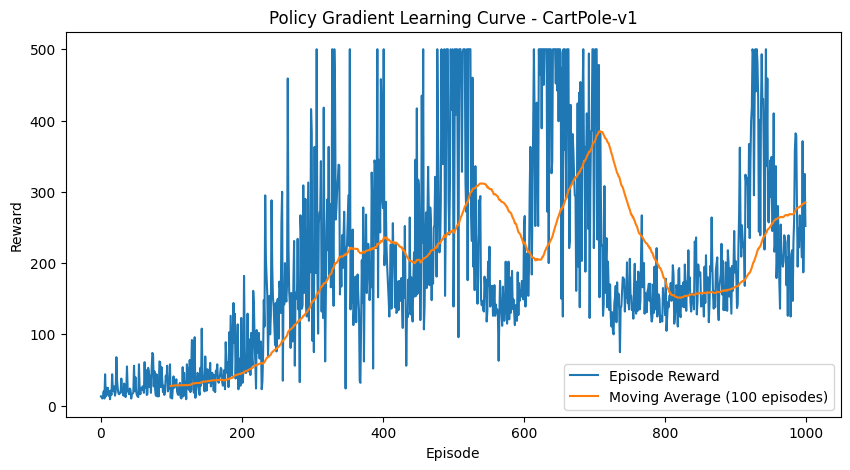


Evaluating trained policy:

Mean Reward: 329.17
Standard Deviation of Reward: 91.14


In [4]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from tqdm import tqdm

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

def train_policy_gradient(env_name, num_episodes, discount_factor, learning_rate):
    env = gym.make(env_name)
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    policy = PolicyNetwork(input_dim, output_dim)
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

    episode_rewards = []
    moving_average_rewards = []

    for episode in tqdm(range(num_episodes), desc="Training Progress"):
        state, _ = env.reset()
        log_probs = []
        rewards = []
        done = False
        
        while not done:
            state_tensor = torch.FloatTensor(state)
            action_probs = torch.softmax(policy(state_tensor), dim=0)
            dist = Categorical(action_probs)
            action = dist.sample()
            
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            
            log_probs.append(dist.log_prob(action))
            rewards.append(reward)
            
            state = next_state
        
        episode_reward = sum(rewards)
        episode_rewards.append(episode_reward)
        
        if len(episode_rewards) >= 100:
            moving_avg = np.mean(episode_rewards[-100:])
            moving_average_rewards.append(moving_avg)
        
        discounted_rewards = []
        R = 0
        for r in reversed(rewards):
            R = r + discount_factor * R
            discounted_rewards.insert(0, R)
        discounted_rewards = torch.FloatTensor(discounted_rewards)
        
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)
        
        loss = []
        for log_prob, R in zip(log_probs, discounted_rewards):
            loss.append(-log_prob * R)
        loss = torch.stack(loss).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (episode + 1) % 100 == 0:
            tqdm.write(f"Episode {episode + 1}, Average Reward: {np.mean(episode_rewards[-100:]):.2f}")

    return policy, episode_rewards, moving_average_rewards

# Training
env_name = "CartPole-v1"
num_episodes = 1000
discount_factor = 0.95
learning_rate = 0.001

trained_policy, episode_rewards, moving_average_rewards = train_policy_gradient(env_name, num_episodes, discount_factor, learning_rate)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards, label='Episode Reward')
plt.plot(range(99, len(episode_rewards)), moving_average_rewards, label='Moving Average (100 episodes)')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title(f'Policy Gradient Learning Curve - {env_name}')
plt.legend()
plt.show()

def evaluate_policy(env_name, policy, num_episodes=100):
    env = gym.make(env_name)
    rewards = []

    for _ in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            state_tensor = torch.FloatTensor(state)
            action_probs = torch.softmax(policy(state_tensor), dim=0)
            action = torch.argmax(action_probs).item()
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward

        rewards.append(episode_reward)

    env.close()
    return rewards

print("\nEvaluating trained policy:")
evaluation_rewards = evaluate_policy(env_name, trained_policy)

mean_reward = np.mean(evaluation_rewards)
std_reward = np.std(evaluation_rewards)
print(f"\nMean Reward: {mean_reward:.2f}")
print(f"Standard Deviation of Reward: {std_reward:.2f}")

In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

def preprocess(image):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 2D float array """
    image = image[35:195] # crop
    image = image[::2, ::2, 0] # downsample by factor of 2
    image[image == 144] = 0 # erase background (background type 1)
    image[image == 109] = 0 # erase background (background type 2)
    image[image != 0] = 1 # everything else (paddles, ball) just set to 1
    return torch.FloatTensor(image.astype(np.float32).ravel()).unsqueeze(0)

# Policy network for Pong
class PongPolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PongPolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 200),
            nn.ReLU(),
            nn.Linear(200, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

# Training function for Pong
def train_policy_gradient_pong(env_name, num_episodes, discount_factor, learning_rate):
    env = gym.make(env_name)
    input_dim = 80 * 80  # Preprocessed image size
    output_dim = 2  # RIGHT and LEFT actions

    policy = PongPolicyNetwork(input_dim, output_dim)
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

    episode_rewards = []
    moving_average_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        state = preprocess(state)
        log_probs = []
        rewards = []
        
        while True:
            action_probs = torch.softmax(policy(state), dim=1)
            dist = Categorical(action_probs)
            action = dist.sample()
            
            # Map action to Pong action space (2: RIGHT, 3: LEFT)
            pong_action = action.item() + 2
            
            next_state, reward, done, _ = env.step(pong_action)
            next_state = preprocess(next_state)
            
            log_probs.append(dist.log_prob(action))
            rewards.append(reward)
            
            state = next_state
            
            if done:
                break
        
        episode_reward = sum(rewards)
        episode_rewards.append(episode_reward)
        
        # Calculate moving average
        if len(episode_rewards) >= 100:
            moving_avg = np.mean(episode_rewards[-100:])
            moving_average_rewards.append(moving_avg)
        
        # Calculate discounted rewards
        discounted_rewards = []
        R = 0
        for r in reversed(rewards):
            R = r + discount_factor * R
            discounted_rewards.insert(0, R)
        discounted_rewards = torch.FloatTensor(discounted_rewards)
        
        # Normalize discounted rewards
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)
        
        # Calculate loss and update policy
        loss = []
        for log_prob, R in zip(log_probs, discounted_rewards):
            loss.append(-log_prob * R)
        loss = torch.stack(loss).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}, Average Reward: {np.mean(episode_rewards[-100:]):.2f}")

    return policy, episode_rewards, moving_average_rewards

# Training
env_name = 'ALE/Pong-v5'
num_episodes = 1000
discount_factor = 0.99
learning_rate = 0.01

trained_policy, episode_rewards, moving_average_rewards = train_policy_gradient_pong(env_name, num_episodes, discount_factor, learning_rate)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards, label='Episode Reward')
plt.plot(range(99, len(episode_rewards)), moving_average_rewards, label='Moving Average (100 episodes)')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title(f'Policy Gradient Learning Curve - {env_name}')
plt.legend()
plt.show()

# Evaluation function for Pong
def evaluate_policy_pong(env_name, policy, num_episodes=500):
    env = gym.make(env_name)
    rewards = []

    for _ in range(num_episodes):
        state = env.reset()
        state = preprocess(state)
        episode_reward = 0
        done = False

        while not done:
            action_probs = torch.softmax(policy(state), dim=1)
            action = torch.argmax(action_probs).item()
            pong_action = action + 2  # Map to Pong action space
            next_state, reward, done, _ = env.step(pong_action)
            state = preprocess(next_state)
            episode_reward += reward

        rewards.append(episode_reward)

    return rewards

evaluation_rewards = evaluate_policy_pong(env_name, trained_policy)

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(evaluation_rewards, bins=20)
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.title(f'Histogram of Rewards over 500 Episodes - {env_name}')
plt.show()

# Calculate mean and standard deviation
mean_reward = np.mean(evaluation_rewards)
std_reward = np.std(evaluation_rewards)
print(f"Mean Reward: {mean_reward:.2f}")
print(f"Standard Deviation of Reward: {std_reward:.2f}")

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


TypeError: tuple indices must be integers or slices, not tuple